# ML project for Sure Tomorrow Insurance Company

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning. The purpose of this project was to to evaluate that possibility, and solve the following tasks: 

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

Below are the libraries used for analysis. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import f1_score
from  sklearn.neighbors import KNeighborsClassifier
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
import math 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Load Data

The data provided by the Sure Tomorrow insurance company was saved in the `df` variable. 

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We renamed the columns to make the code more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.head(10)

,gender,age,income,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


The `df` table contains a total of 5,000 entries (no null values), each describing one costumer; and 5 columns, which are described below: 
- `gender`: gender of costumer
- `age`: age of costumer 
- `income`: anual income of costumer 
- `family_members`: number of family members under costumer's account
- `insurance_benefits`: number of insurance benefits received by an insured person over the last five years.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


## Processing Data for Analysis
In this section, we processed the data to ensure that there were not errors in data type, anomalies in values, or duplicates. 

### Processing `gender` column
The `gender` column had a data type of int64, which is an appropriate datatype. There were two unique integer values for `gender` including 1 and 0. The correspondence of gender to a value (0 or 1) was not provided by Sure Tomorrow. 

In [6]:
df.gender.unique()

array([1, 0])

### Processing `age` column
The `age` column had a datatype of float64, which was changed to int64 datatype, shown below. There were no errors in the values for age, e.g. no negative numbers. There were a total of 12 outliers for the age, which were greater than 1.5*IQR. THese values were removed from the `df` dataframe. 

In [7]:
#changing data type float64 to int64
df['age']=df.age.astype('int')
df.age.head(10)

0    41
1    46
2    29
3    21
4    28
5    43
6    39
7    25
8    36
9    32
Name: age, dtype: int64

In [8]:
#checking for unique values 
print(sorted(df.age.unique()))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 65]


In [9]:
#looking for outliers
q1_age = df.age.quantile(0.25)
q3_age = df.age.quantile(0.75)
iqr_age = q3_age - q1_age

outlier_age = df.query('age > (@q3_age + (1.5 * @iqr_age)) or age < (@q1_age - (1.5 * @iqr_age))')
print(len(outlier_age))
outlier_age

12


,gender,age,income,family_members,insurance_benefits
228,1,65,39700.0,1,5
256,0,57,28100.0,2,3
1126,1,58,28300.0,1,3
1215,1,58,26500.0,0,3
1568,1,59,32100.0,0,4
2240,0,60,27900.0,0,4
3102,0,57,22600.0,2,3
3117,0,60,43400.0,2,4
3209,1,59,51700.0,2,4
3674,1,59,29600.0,0,4


In [10]:
#saving changes in df
df=df.drop(outlier_age.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4988 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4988 non-null   int64  
 1   age                 4988 non-null   int64  
 2   income              4988 non-null   float64
 3   family_members      4988 non-null   int64  
 4   insurance_benefits  4988 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 233.8 KB


### Processing `income` column
The income column has data type as float64, and was changed to int64 data type, so we could have values to the nearest dollar. There were no error in the income values, such as negative values. There were a total of 37 values that were outliers greater and smaller than 1.5*iqr. 

In [11]:
df['income']=df.income.astype('int')
print(sorted(df.income.unique()))

[5300, 6000, 7400, 8900, 9800, 10000, 10600, 10800, 11000, 11200, 11300, 12200, 12900, 13000, 13200, 13300, 13400, 13500, 13800, 13900, 14100, 14300, 14400, 14500, 14600, 14700, 15000, 15100, 15200, 15600, 15700, 15900, 16000, 16200, 16300, 16400, 16500, 16600, 16700, 17000, 17100, 17300, 17400, 17500, 17600, 17700, 17800, 17900, 18100, 18200, 18300, 18400, 18600, 18700, 18800, 18900, 19000, 19100, 19200, 19300, 19400, 19600, 19700, 19900, 20000, 20100, 20200, 20300, 20400, 20500, 20600, 20700, 20800, 20900, 21000, 21100, 21200, 21300, 21400, 21500, 21600, 21700, 21800, 21900, 22000, 22100, 22200, 22300, 22500, 22600, 22700, 22800, 22900, 23000, 23100, 23200, 23300, 23400, 23500, 23600, 23700, 23800, 23900, 24000, 24100, 24200, 24300, 24400, 24500, 24600, 24700, 24800, 24900, 25000, 25100, 25200, 25300, 25400, 25500, 25600, 25700, 25800, 25900, 26000, 26100, 26200, 26300, 26400, 26500, 26600, 26700, 26800, 26900, 27000, 27100, 27200, 27300, 27400, 27500, 27600, 27700, 27800, 27900, 280

In [12]:
#looking for outliers
q1_inc = df.income.quantile(0.25)
q3_inc = df.income.quantile(0.75)
iqr_inc = q3_inc - q1_inc

outlier_inc = df.query('income > (@q3_inc + (1.5 * @iqr_inc)) or income < (@q1_inc - (1.5 * @iqr_inc))')
print(len(outlier_inc))
outlier_inc

37


,gender,age,income,family_members,insurance_benefits
42,1,42,69200,0,1
425,1,30,67700,0,0
437,0,28,8900,4,0
483,0,29,9800,2,0
726,1,20,5300,1,0
1095,0,25,11300,2,0
1309,0,34,12900,2,0
1545,1,28,13000,1,0
1891,1,30,70600,0,0
2087,1,21,68000,2,0


In [13]:
#saving changes to df dataframe
df=df.drop(outlier_inc.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4951 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              4951 non-null   int64
 1   age                 4951 non-null   int64
 2   income              4951 non-null   int64
 3   family_members      4951 non-null   int64
 4   insurance_benefits  4951 non-null   int64
dtypes: int64(5)
memory usage: 232.1 KB


### Processing `family_members` column
For the family members column, there were a total of 7 unique values, and none of these values were errors, such as negative values. The data type for this column was int64, which is appropriate.

In [14]:
df.family_members.unique()

array([1, 0, 2, 4, 3, 5, 6])

### Processing `insurance_benefits` column
The insurance_benefits column had a data type of int64, which was an appropriate data type. There were no errors in data values for this column. 

In [15]:
df.insurance_benefits.unique()

array([0, 1, 2, 3])

### Description of `df` after data processing 
After data processing, the resulting `df` used for analysis, had a total of 4,951 entries, which did not contain any outliers for age and income values. The data type for all of the columns was int64. 

In [16]:
df.reset_index(drop=True, inplace=True)
print(df)
df.info()

      gender  age  income  family_members  insurance_benefits
0          1   41   49600               1                   0
1          0   46   38000               1                   1
2          0   29   21000               0                   0
3          0   21   41700               2                   0
4          1   28   26100               0                   0
...      ...  ...     ...             ...                 ...
4946       0   28   35700               2                   0
4947       0   34   52400               1                   0
4948       0   20   33900               2                   0
4949       1   22   32700               3                   0
4950       1   28   40600               1                   0

[4951 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              4951 n

## EDA

In this section, we examined whether there are certain groups of customers by looking at the pair plot.

From the pair plot below, we observed the following groups of costumers: 
- gender vs. gender: There's a balanace in gender classes, as 50.1% of the entries are 0 and 49.8% are 1. 
- gender vs. age: the pair plot illustrates higher density of entries for clients that are younger than 40 years of age, independently of geder. 
- gender vs. income: 

In [17]:
len(df.query('gender ==1'))/len(df)

0.4982831751161382

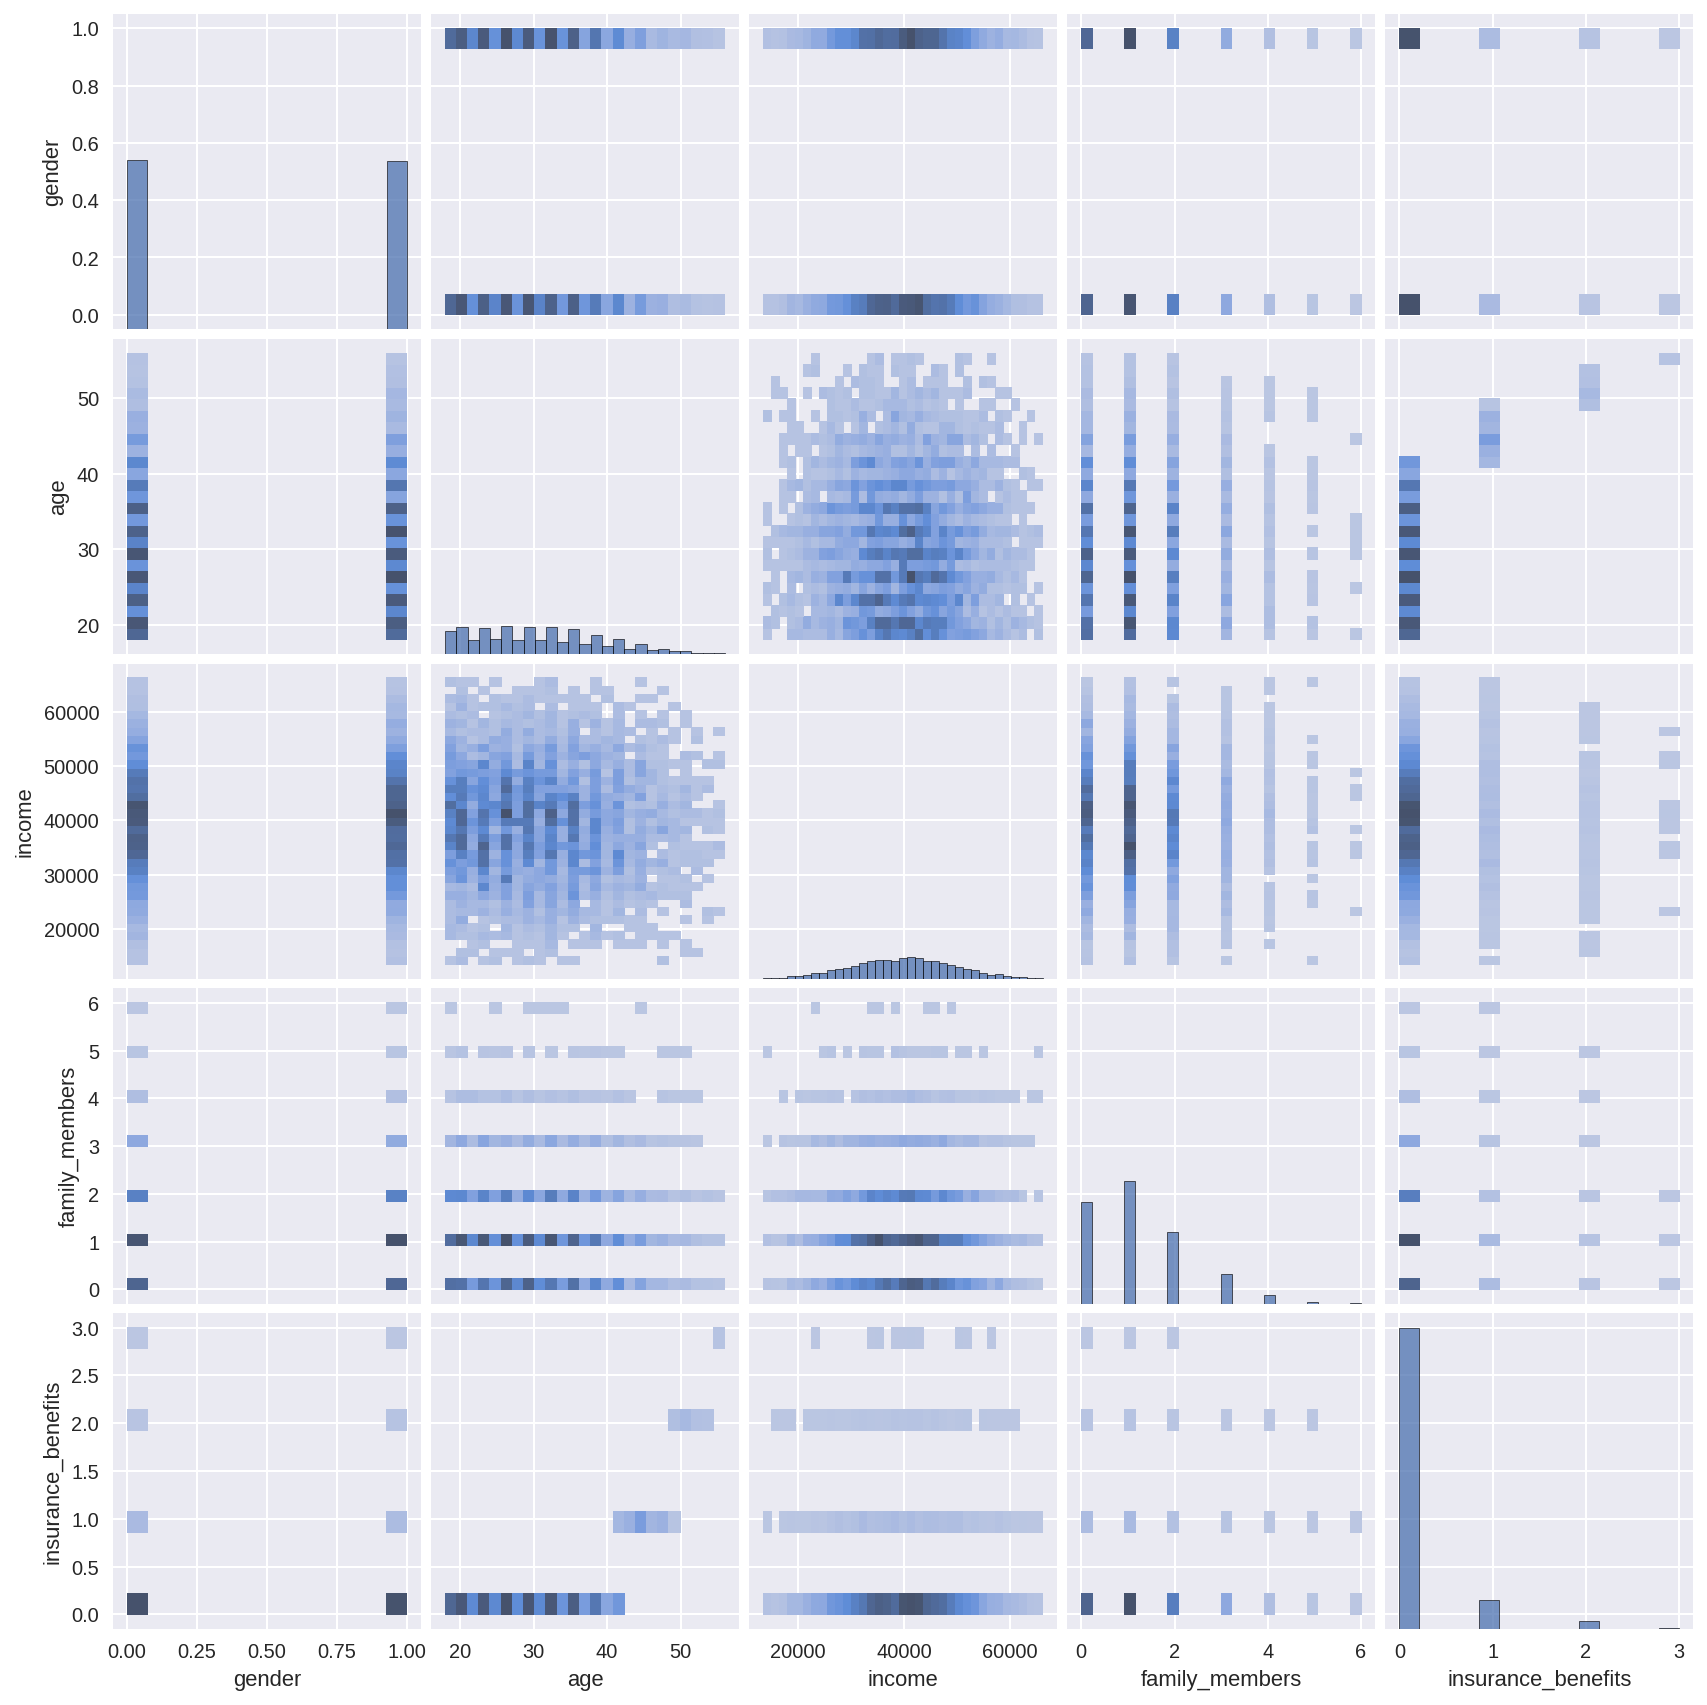

In [18]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

## Task 1. Similar Customers

For this section, we created a function that returned the __k__ nearest neighbors for an $n^{th}$ object based on a specified distance metric. The received insurance benefits were not take into account to find the __k__ nearest neighbors. For this project, the $n^{th}$ object selected was the client that had an income value equals to the median income distribution and the smallest index number from that selection. In this case we selected index 40 as our $n^{th}$ value, and 10 as our k neighbors value. For this section, analyzed the 10 nearest neighbors by using the 4 different combinations: 
- using non-scaled data and Euclidean distance to calculate the 10 nearest neighbors. 
- using non-scaled data and Manhattan distance to calculate the 10 nearest neighbors. 
- using scaled data and Euclidean distance to calculate the 10 nearest neighbors. 
- using scaled data and Manhattan distance to calculate the 10 nearest neighbors. 

The resulting 10 nearest neighbors and distances were analyzed for each combination, and the following questions were answered in the conclusion of this section: 

- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [19]:
selected_nth= df.query('income == income.quantile(0.5)').head(1).index.tolist()[0]

selected_k =11
selected_nth

40

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [21]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n, metric=metric, algorithm='brute')
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

### Non-scaled `df` , finding 10 nearest neighbors using dist. metrics: Euclidean and Manhattan

In this section, we found the 10 nearest neighbors to the client with index 40 using two distance metrics: Euclidean and Manhattan, with our non-scaled `df` dataframe. From the resulting datadrames, we observed that both metrics calculated the same indices for the 10 nearest neighbors; however, clients with index 947 and 3861 had 3rd and 4th position, respectively, as the closest neighbors with the distance metrix, euclidean. However, clients 947 and 2861 had 4th and 3rd positions, respectively, as the closest neighbors with the distance metrix, manhattan. The rest of the clients had the same position in both dataframes of each distance metric. 


The distance for the non-scaled, Euclidean metric had a mean distance of 6.52 distance units compared to 7.45 distance units for the Manhattan metric; the Euclidean metric distance distribution had a standard deviation value of 3.31 distance units compared to 3.61 distance units for the distance distributon of Manhattan metric; and the Euclidean had a median distance value of 6.08 distance units compared 7.00 distance units for the distance distribution of Manhattan metric. 

In [22]:
#Euclidean metric 
not_scaled_euclidean = get_knn(df=df, n=selected_nth, k=selected_k, metric='euclidean')
print(not_scaled_euclidean.distance.describe())
not_scaled_euclidean.sort_values('distance')

count    11.000000
mean      6.523393
std       3.315099
min       0.000000
25%       4.561553
50%       6.082763
75%       8.558821
max      12.041595
Name: distance, dtype: float64


,gender,age,income,family_members,insurance_benefits,distance
40,1,42,40200,0,1,0.000000
1537,0,38,40200,0,0,4.123106
2570,0,38,40200,0,0,4.123106
947,1,46,40200,3,1,5.000000
3861,1,36,40200,0,0,6.000000
264,0,36,40200,0,0,6.082763
3880,1,35,40200,1,0,7.071068
4835,0,34,40200,0,0,8.062258
2965,1,33,40200,1,0,9.055385
3218,1,32,40200,2,0,10.198039


In [23]:
#Manhattan Metric
not_scaled_manhattan = get_knn(df=df, n=selected_nth, k=selected_k, metric='manhattan')
print(not_scaled_manhattan.distance.describe())
not_scaled_manhattan.sort_values('distance')

count    11.000000
mean      7.454545
std       3.615623
min       0.000000
25%       5.500000
50%       7.000000
75%       9.500000
max      13.000000
Name: distance, dtype: float64


,gender,age,income,family_members,insurance_benefits,distance
40,1,42,40200,0,1,0.0
1537,0,38,40200,0,0,5.0
2570,0,38,40200,0,0,5.0
3861,1,36,40200,0,0,6.0
947,1,46,40200,3,1,7.0
264,0,36,40200,0,0,7.0
3880,1,35,40200,1,0,8.0
4835,0,34,40200,0,0,9.0
2965,1,33,40200,1,0,10.0
3218,1,32,40200,2,0,12.0


In [24]:
# comparing indices of both metrics 
print(not_scaled_manhattan.sort_values('distance').index.tolist())
not_scaled_euclidean.sort_values('distance').index.tolist()

[40, 1537, 2570, 3861, 947, 264, 3880, 4835, 2965, 3218, 3888]


[40, 1537, 2570, 947, 3861, 264, 3880, 4835, 2965, 3218, 3888]

### Scaled `df` , finding 10 nearest neighbors using dist. metrics: Euclidean and Manhattan

In this section, we found the 10 nearest neighbors to the client with index 40 using two distance metrics: Euclidean and Manhattan, with our scaled `df` dataframe saved as `df_scaled`. 

From the resulting datadrames, we observed that both metrics calculated the same 9 indices, with the exception that Manhattan metric calculated index 1340 as one of the 10 nearest neighbors, which is not part from the list using Euclidean metric; and Euclidean metric calculated index 578 as one of the 10 nearest neighbors, which is not part from the list using Manhattan metric


The distance for the scaled df, Euclidean metric had a mean distance of 0.027 distance units compared to 0.033 distance units for the Manhattan metric; the Euclidean metric distance distribution had a standard deviation value of 0.014 distance units compared to 0.017 distance units for the distance distributon of Manhattan metric; and the Euclidean had a median distance value of 0.033 distance units compared 0.043 distance units for the distance distribution of Manhattan metric. 

In [25]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [26]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2049,1.0,0.410714,0.648567,0.166667,0
559,1.0,0.500000,0.654600,0.000000,0
4930,1.0,0.821429,0.867270,0.333333,1
641,1.0,0.589286,0.595777,0.166667,0
1680,0.0,0.321429,0.453997,0.000000,0


In [27]:
#Euclidean metric 
scaled_euclidean = get_knn(df=df_scaled, n=selected_nth, k=selected_k, metric='euclidean')
print(scaled_euclidean.distance.describe())
scaled_euclidean.sort_values('distance')

count    11.000000
mean      0.027574
std       0.014588
min       0.000000
25%       0.020065
50%       0.033766
75%       0.038207
max       0.043741
Name: distance, dtype: float64


,gender,age,income,family_members,insurance_benefits,distance
40,1.0,0.750000,0.606335,0.0,1,0.000000
1539,1.0,0.750000,0.610860,0.0,1,0.004525
4928,1.0,0.732143,0.598793,0.0,0,0.019384
1861,1.0,0.732143,0.616893,0.0,0,0.020745
3305,1.0,0.750000,0.636501,0.0,1,0.030166
953,1.0,0.732143,0.634992,0.0,0,0.033766
578,1.0,0.767857,0.638009,0.0,1,0.036361
4217,1.0,0.714286,0.592760,0.0,0,0.038207
4381,1.0,0.714286,0.592760,0.0,0,0.038207
2264,1.0,0.714286,0.619910,0.0,0,0.038207


In [28]:
#Manhattan metric 
scaled_manhattan = get_knn(df=df_scaled, n=selected_nth, k=selected_k, metric='manhattan')
print(scaled_manhattan.distance.describe())
scaled_manhattan.sort_values('distance')

count    11.000000
mean      0.033807
std       0.017954
min       0.000000
25%       0.026907
50%       0.043741
75%       0.047902
max       0.049289
Name: distance, dtype: float64


,gender,age,income,family_members,insurance_benefits,distance
40,1.0,0.750000,0.606335,0.0,1,0.000000
1539,1.0,0.750000,0.610860,0.0,1,0.004525
4928,1.0,0.732143,0.598793,0.0,0,0.025399
1861,1.0,0.732143,0.616893,0.0,0,0.028415
3305,1.0,0.750000,0.636501,0.0,1,0.030166
4166,1.0,0.750000,0.650075,0.0,1,0.043741
1340,1.0,0.750000,0.561086,0.0,1,0.045249
953,1.0,0.732143,0.634992,0.0,0,0.046515
4217,1.0,0.714286,0.592760,0.0,0,0.049289
4381,1.0,0.714286,0.592760,0.0,0,0.049289


In [29]:
# comparing indices of both metrics 
print(scaled_manhattan.sort_values('distance').index.tolist())
scaled_euclidean.sort_values('distance').index.tolist()

[40, 1539, 4928, 1861, 3305, 4166, 1340, 953, 4217, 4381, 2264]


[40, 1539, 4928, 1861, 3305, 953, 578, 4217, 4381, 2264, 4166]

### Conclusions From calculating the 10 Nearest Neighbors
From calculating the 10 nearest neighbors, we found data not being scaled results is larger distance distributions compared to scaled data. For instance, the euclidean distances using non-scaled data produced a mean, standard deviation, and median distance values of 6.52, 3.31, and 6.08, respectively; compared to euclidean distances from scaled data that produced a mean, standard deviation, and median distances values of 0.027, 0.014, and 0.033, respectively. The same patter showed with Manhattan distances using non-scaled data, which produced a mean, standard deviation, and median distance values 7.45, 3.61, and 7.00, respectively; compared to manhattan distances using scaled data that produces mean, standard deviation, and median values of 0.033, 0.017, and 0.043, respectively. 

Another observation we noticed from this section is that calculating manhattan distances, does not affect the distribution of distances significantly, independently of scaling the data. The pattern we noticed is that the distribution, compared to euclidean distance distribution, is shifted to the right. In other words, manhattan distances share a similar distribution to euclidean distances, but its center of distribution is located at a higher distance value. 

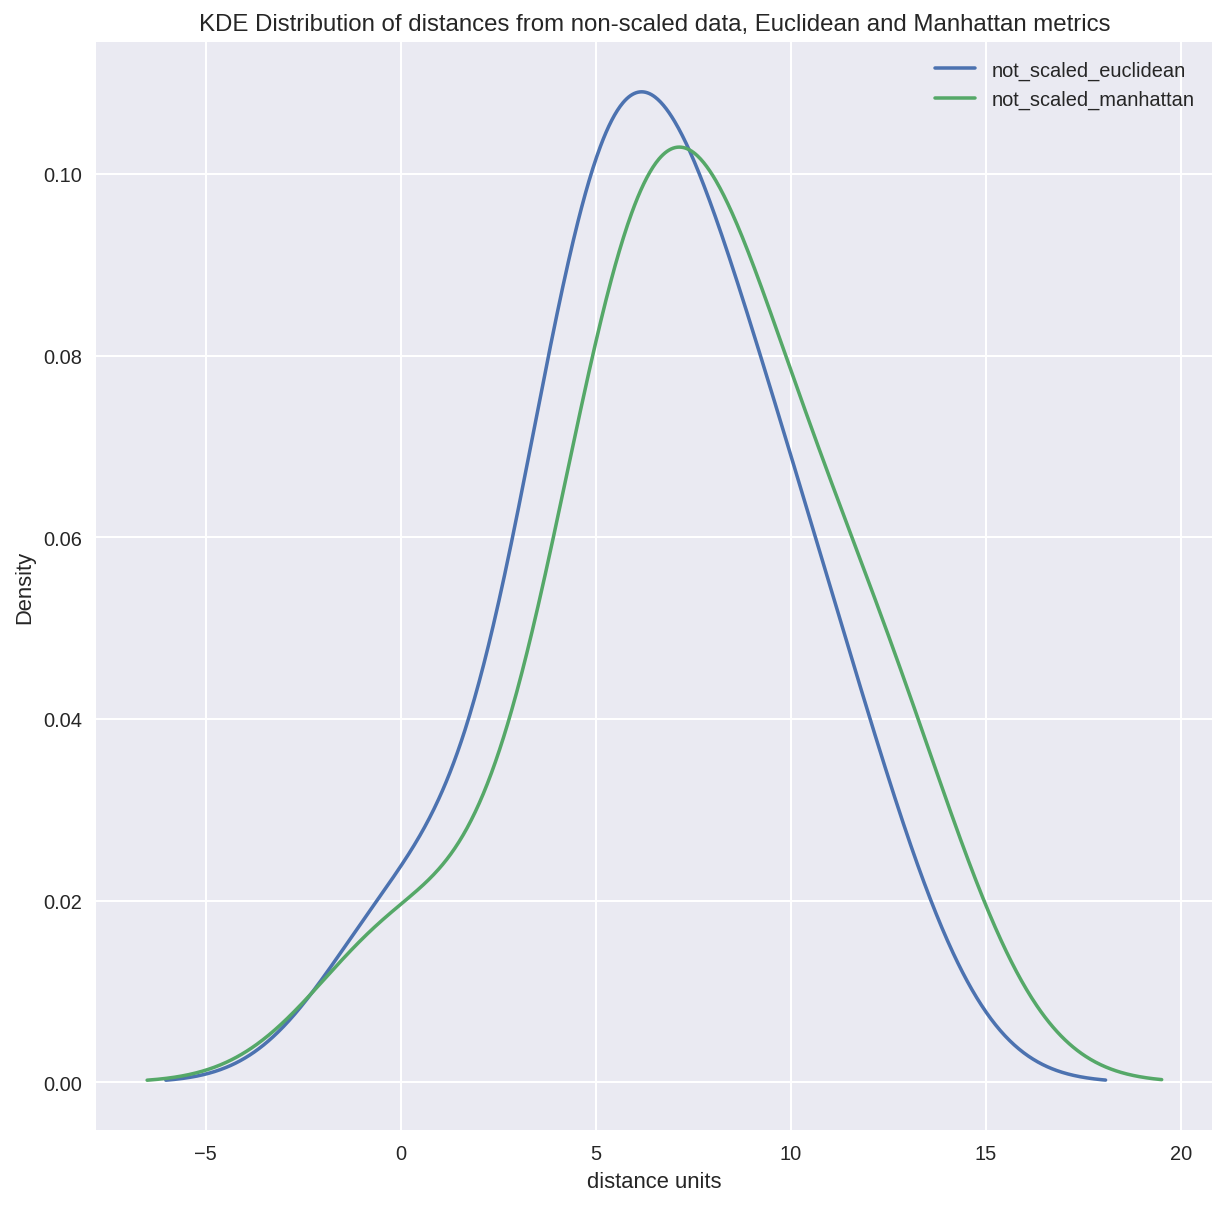

In [30]:
plt.figure(figsize=(10,10))
not_scaled_euclidean.distance.plot.kde(label='not_scaled_euclidean')
not_scaled_manhattan.distance.plot.kde(label='not_scaled_manhattan')
plt.title('KDE Distribution of distances from non-scaled data, Euclidean and Manhattan metrics')
plt.xlabel('distance units')
plt.legend(loc='best')
plt.show()

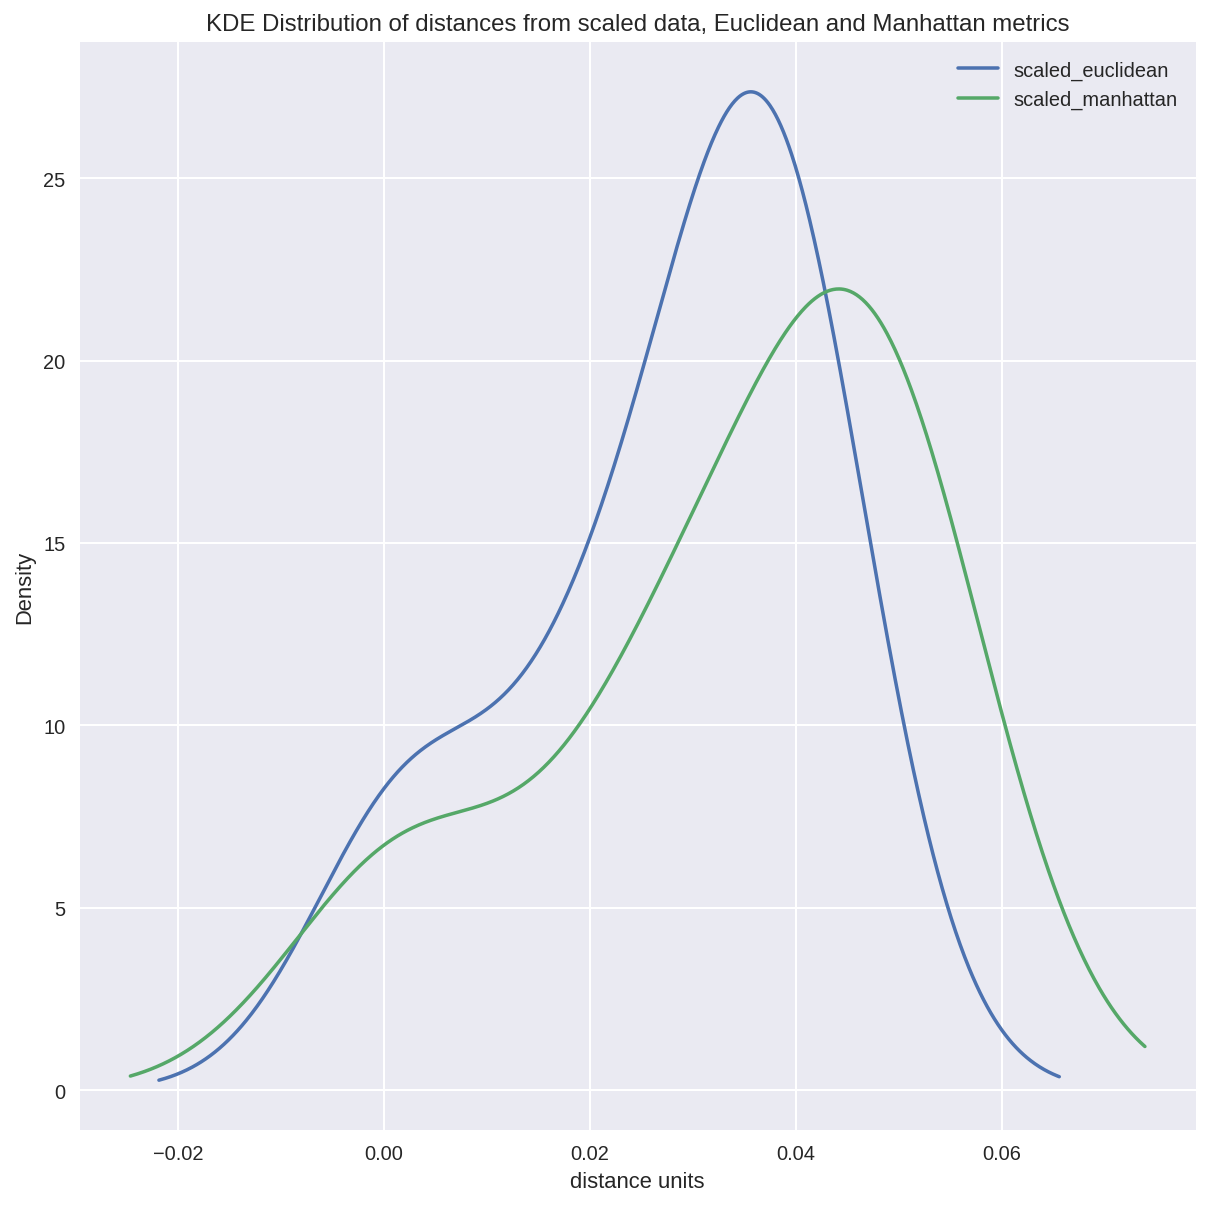

In [31]:
#distance distribution from scaled data
plt.figure(figsize=(10,10))
scaled_euclidean.distance.plot.kde(label='scaled_euclidean')
scaled_manhattan.distance.plot.kde(label='scaled_manhattan')
plt.title('KDE Distribution of distances from scaled data, Euclidean and Manhattan metrics')
plt.xlabel('distance units')
plt.legend(loc='best')
plt.show()

From the resulting 10 nearest neighbors, we observed that scaled and non-scaled data selected different neighbors for each distance. For instance, non-scaled and scaled euclidean did not share any neighor in common; similarly, non-scaled and scaled manhattan did not share any neighbor in common. We can conclude that with unscaled data, if some feature has a much bigger magnitude than others (for example, income), it is weighed much more in the distance calculation than other features. Scaling makes all features weighed equally.

In [32]:
list_A = sorted(not_scaled_euclidean.index.to_list())
list_B = sorted(scaled_euclidean.index.to_list())
print('not_scaled_euclidean indices')
print(list_A)
print('scaled_euclidean indices')
print(list_B)
print('Neighbors sahred by non-scaled and scaled euclidean distance')
print(set(list_A).intersection(list_B))
print()
print()
list_a = sorted(not_scaled_manhattan.index.to_list())
list_b = sorted(scaled_manhattan.index.to_list())
print('not_scaled_manhattan indices')
print(list_a)
print('scaled_manhattan indices')
print(list_b)
print('Neighbors sahred by non-scaled and scaled manhattan distance')
set(list_a).intersection(list_b)

not_scaled_euclidean indices
[40, 264, 947, 1537, 2570, 2965, 3218, 3861, 3880, 3888, 4835]
scaled_euclidean indices
[40, 578, 953, 1539, 1861, 2264, 3305, 4166, 4217, 4381, 4928]
Neighbors sahred by non-scaled and scaled euclidean distance
{40}


not_scaled_manhattan indices
[40, 264, 947, 1537, 2570, 2965, 3218, 3861, 3880, 3888, 4835]
scaled_manhattan indices
[40, 953, 1340, 1539, 1861, 2264, 3305, 4166, 4217, 4381, 4928]
Neighbors sahred by non-scaled and scaled manhattan distance


{40}

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In this section, we created a KNN-based classifier to test how the value of __K__ (Number of neighbors) affects the F1 score metric, as well to observe whether scaling the data makes any difference. Since the values in the `insurance_benefits` column have more values of zero as the target, we wanted to evaluate if out KNN classifier model could perform between than a dummy model. For the KNN classifer model and the dummy model, we added a new column to `df` called __insurance_benefits_received__, which takes the values from the __insurance_benefits__ column. If a value in the __insurance_benefits__ column has a value greater than 0, then it takes a value of 1 in the __insurance_benefis_received__ column; if a value in the __insurance_benefits__ column has a value equals to 0, then it takes a value of 0 in the __insurance_benefis_received__ column. The purpose of the dummy model is to calculate the different probabilities of getting 1, or insurance benefits, at random. Different probalities tested were 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$


In [33]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')


As mentioned previously, there was an inbalance in the classes for the __insurance_benefits_received__ target. The class 0 presented 88.93%, while class 1 presented 11.06% of the values in the __insurance_benefits_received__ column. 

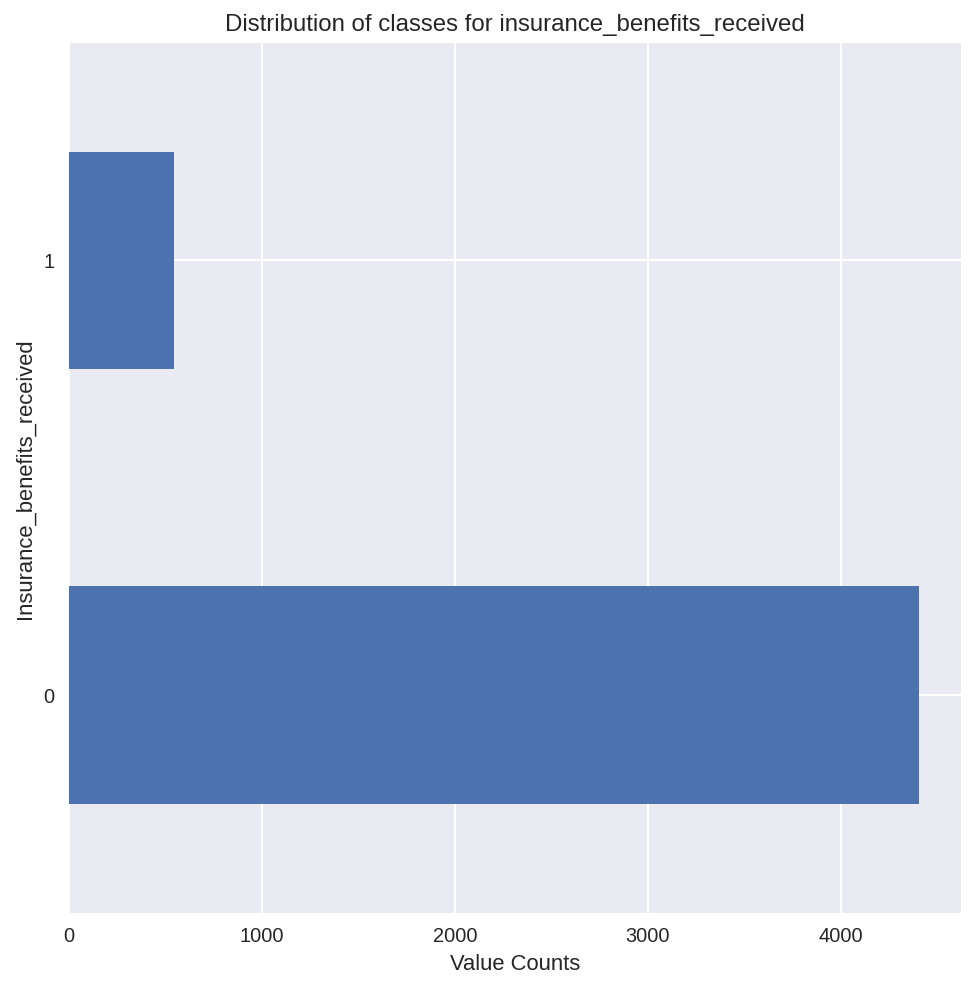

0    0.889315
1    0.110685
Name: insurance_benefits_received, dtype: float64

In [34]:
# check for the class imbalance with value_counts()
df.insurance_benefits_received.value_counts().plot(kind = 'barh', figsize=(8,8))
plt.xlabel('Value Counts')
plt.ylabel('Insurance_benefits_received')
plt.title('Distribution of classes for insurance_benefits_received')
plt.show ()
df.insurance_benefits_received.value_counts(normalize=True)

For the dummy model, we printed the probabilities of obtaining 1, at random, from the __insurance_benefits_received__ target; as well, as the F1 score and the confusion matrix for each probabilitiy. The results are shown below: 

In [35]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [36]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [37]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88931529 0.        ]
 [0.11068471 0.        ]]

The probability: 0.11
F1: 0.10
Confusion Matrix
[[0.79256716 0.09674813]
 [0.10018178 0.01050293]]

The probability: 0.50
F1: 0.17
Confusion Matrix
[[0.44920218 0.44011311]
 [0.05837205 0.05231266]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.         0.88931529]
 [0.         0.11068471]]



For the KNN-based classifier model, we split the `df` and `df_scaled` dataframes into training and testing datasets, in a 70:30 ratio. The dimensions of each dataset are described below. 

In [38]:
# Split df for train and testing in a 70:30 ratio

features = df[feature_names]
target= df['insurance_benefits_received']

train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.3, random_state=12345)

print('train_features shape', train_features.shape)
print()
print('test_features shape', test_features.shape)
print()
print('train_target shape', train_target.shape)
print()
print('test_target shape', test_target.shape)

train_features shape (3465, 4)

test_features shape (1486, 4)

train_target shape (3465,)

test_target shape (1486,)


In [39]:
# Split df_scaled for train and testing in a 70:30 ratio
df_scaled['insurance_benefits_received']=df['insurance_benefits_received']
scaled_features = df_scaled[feature_names]
scaled_target= df_scaled['insurance_benefits_received']

s_train_features, s_test_features, s_train_target, s_test_target = train_test_split(
    scaled_features, scaled_target, test_size=0.3, random_state=12345)

print('train_features shape', s_train_features.shape)
print()
print('test_features shape', s_test_features.shape)
print()
print('train_target shape', s_train_target.shape)
print()
print('test_target shape', s_test_target.shape)

train_features shape (3465, 4)

test_features shape (1486, 4)

train_target shape (3465,)

test_target shape (1486,)


## Conclusion for task 2
To test how __k__ number of neighbors and metric distance affect the F1 score, we used the class KNeighborsClassifier from sklearn to obtain the F1 scores for each combination possible. For the non-sclaed data, we found that the F1 score tends to decrease when the __k__ number of neighbors increase, for both manhattan and euclidean distances. The distribution of F1 for scaled data, on the other hand, has a more uniform distribution, with k=1 having the highest F1 score for both euclidean and manhattan distances. The combination that had the highest F1 score was scaled_df, manhattan distance, and k=1 with an F1 score of 0.984985, compared to the hihest combination of non_scaled data (k=1, manhattan distance) which had a F1 score of 0.653199. To conclude, the KNN classifier model performed better than the Dummy model.  

In [40]:
# testing how k affects F1 score for predicting 

results=[]
results_scaled=[]
for k in range(1,11):
    for metric in list(['euclidean', 'manhattan']):
        model = KNeighborsClassifier(n_neighbors = k, metric=metric)
        model.fit(train_features, train_target)
        predictions = model.predict(test_features)
        score = f1_score(test_target, predictions)
        results.append(list([metric, k, score]))
        
    for metric in list(['euclidean', 'manhattan']):
        model_scaled = KNeighborsClassifier(n_neighbors = k, metric=metric)
        model_scaled.fit(s_train_features, s_train_target)
        s_predictions = model_scaled.predict(s_test_features)
        s_score = f1_score(s_test_target, s_predictions)
        results_scaled.append(list([metric, k, s_score]))


In [41]:
non_scaled_results = pd.DataFrame(results, columns=['metric', 'k', 'f1_score'])
non_scaled_results.sort_values(['metric','k'])

,metric,k,f1_score
0,euclidean,1,0.653061
2,euclidean,2,0.366972
4,euclidean,3,0.389831
6,euclidean,4,0.170213
8,euclidean,5,0.187500
10,euclidean,6,0.022989
12,euclidean,7,0.022989
14,euclidean,8,0.023392
16,euclidean,9,0.023392
18,euclidean,10,0.011765


In [42]:
scaled_results = pd.DataFrame(results_scaled, columns=['metric', 'k', 'f1_score'])
scaled_results.sort_values(['metric','k'])

,metric,k,f1_score
0,euclidean,1,0.970060
2,euclidean,2,0.937107
4,euclidean,3,0.946108
6,euclidean,4,0.931250
8,euclidean,5,0.929664
10,euclidean,6,0.924528
12,euclidean,7,0.935780
14,euclidean,8,0.925000
16,euclidean,9,0.932099
18,euclidean,10,0.920635


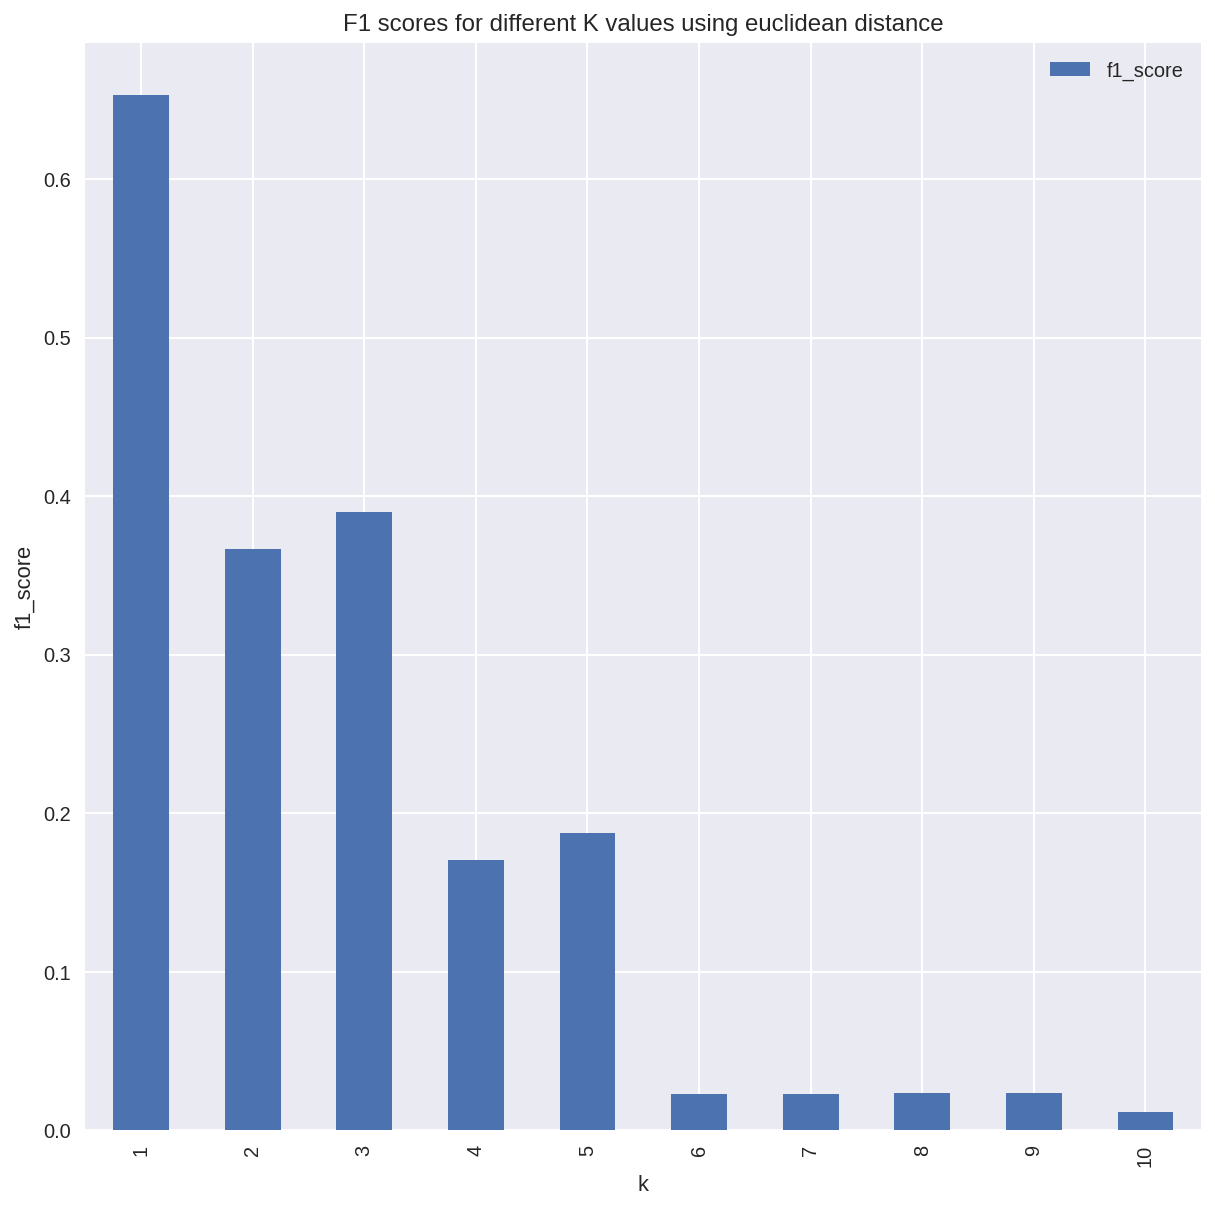

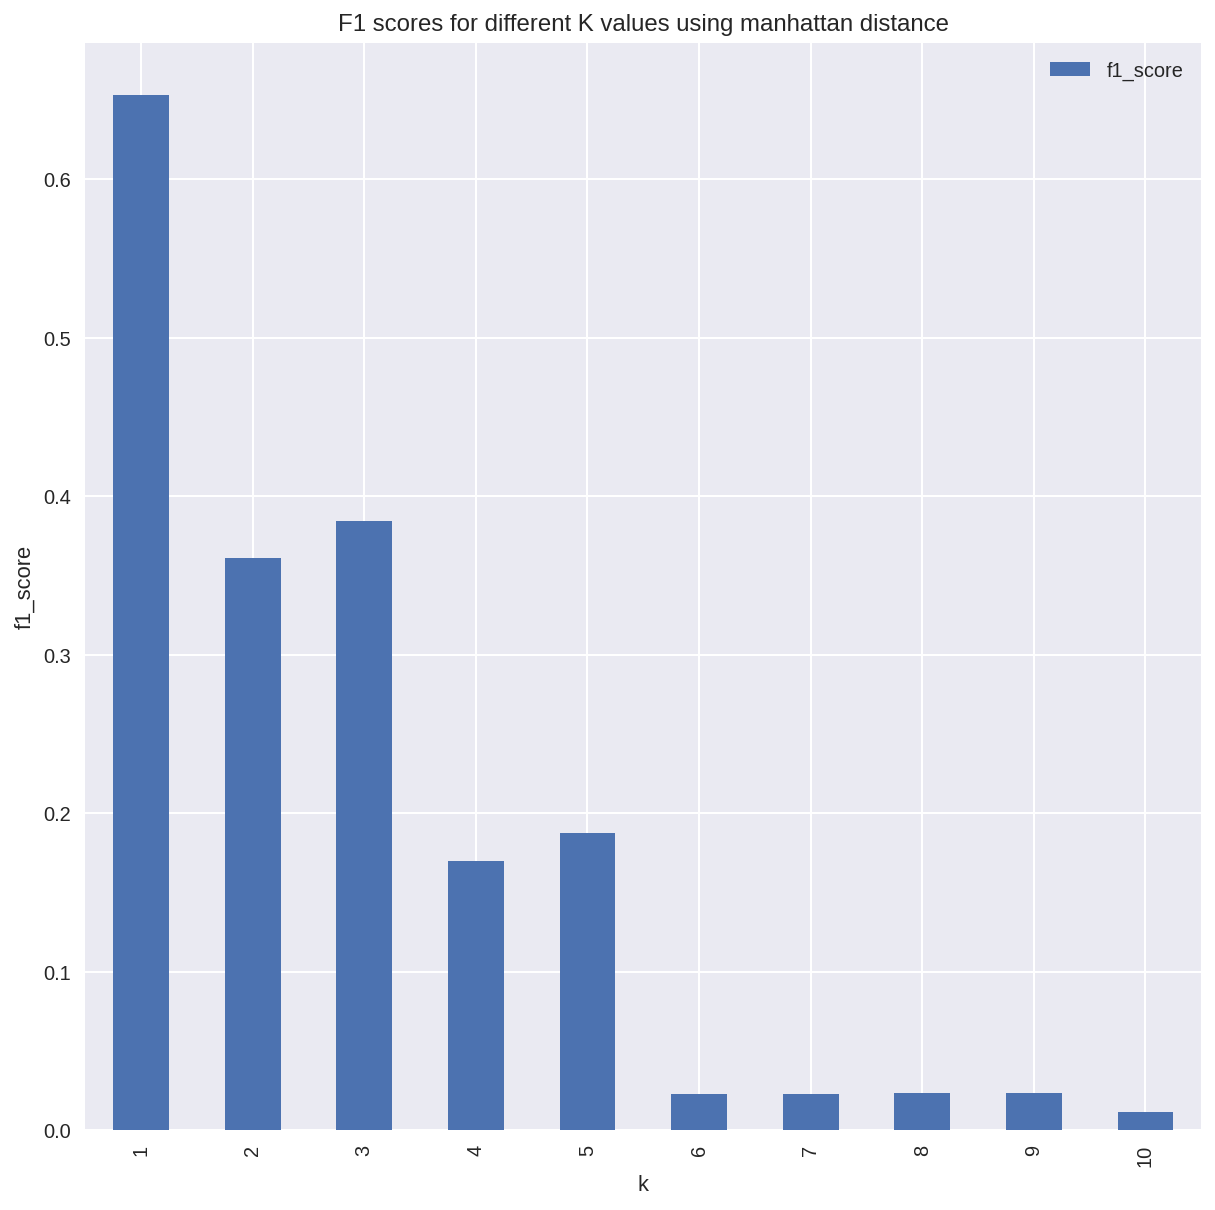

In [43]:
#plotting non_scaled_results
non_scaled_results.query('metric =="euclidean"').plot(kind='bar', x='k', y='f1_score', figsize=(10,10))
plt.ylabel('f1_score')
plt.title('F1 scores for different K values using euclidean distance')
plt.show()
non_scaled_results.query('metric =="manhattan"').plot(kind='bar', x='k', y='f1_score', figsize=(10,10))
plt.ylabel('f1_score')
plt.title('F1 scores for different K values using manhattan distance')
plt.show()

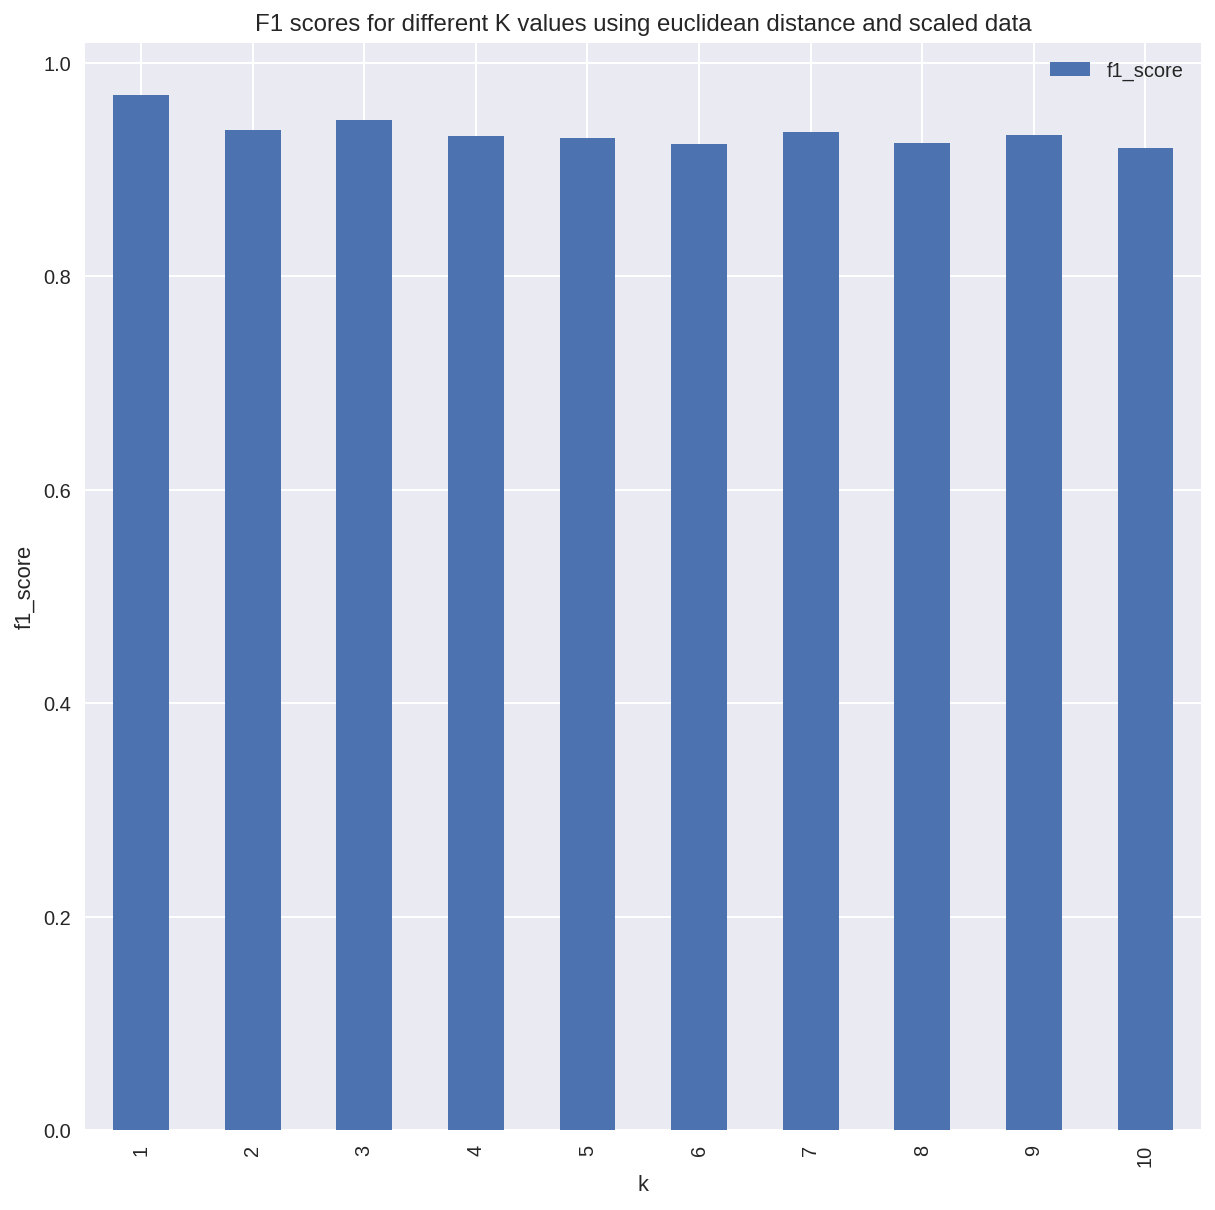

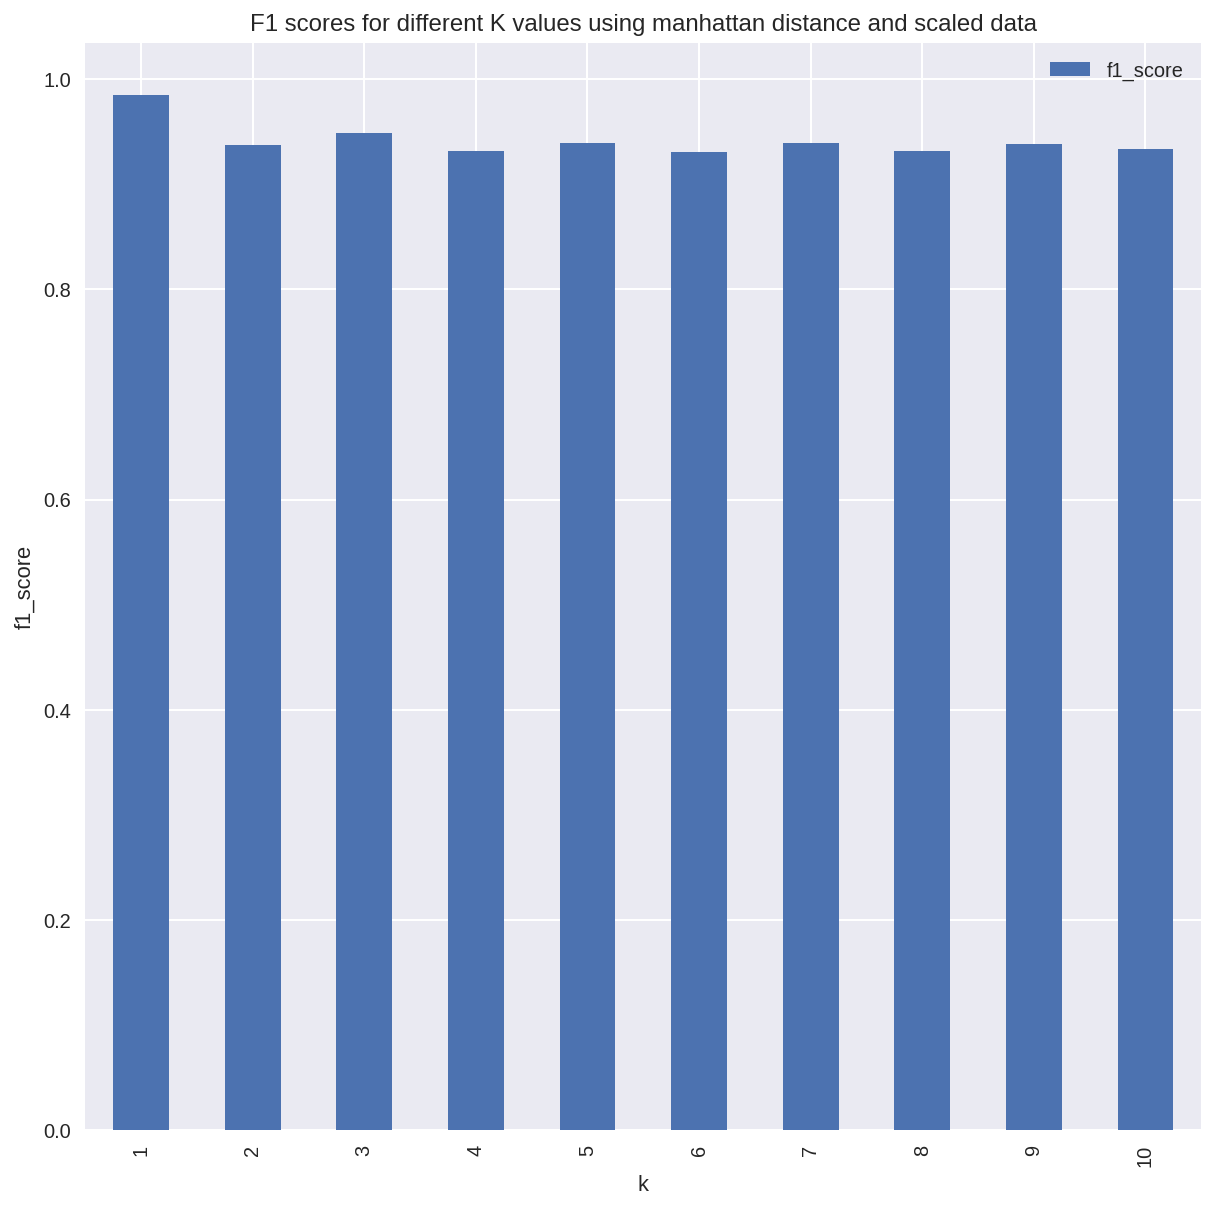

In [44]:
#plotting scaled_results
scaled_results.query('metric =="euclidean"').plot(kind='bar', x='k', y='f1_score', figsize=(10,10))
plt.ylabel('f1_score')
plt.title('F1 scores for different K values using euclidean distance and scaled data')
plt.show()
scaled_results.query('metric =="manhattan"').plot(kind='bar', x='k', y='f1_score', figsize=(10,10))
plt.ylabel('f1_score')
plt.title('F1 scores for different K values using manhattan distance and scaled data')
plt.show()

# Task 3. Regression (with Linear Regression)

We built our own implementation of linear regression and checked the RMSE for a Linear Regression model, wtih `insurance_benefits` as the target. For that, we used the the principles of linear regression to  check RMSE for both the original data and the scaled one and observed where there were any differences in RMSE between these two cases. 

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

## Conclucion for Task 3
We split the whole data in a 70:30 ratio for the training/validation parts, and used the RMSE metric for the model evaluation. From this section, we found the that using an implementation of linear regression for non-scaled, resulted in an RMSE value of 0.34 and R2 values of 0.66. The scaled_df data also resulted in the same values for both metrics. This mean that our model, for both scaled and non-scaled data, the predictions are off by 0.34 points, on average, from the real values of insurance_benefits. We conclude that there is no difference in RMSE between scaled and non-scaled data after implementation of a Linear Regression model. 

In [45]:
class MyLinearRegression: 
    def __init__(self): 
        self.weights = None   
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y     
    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [46]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [47]:
#checking RMSE and R2 for non_scaled data 
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-8.49446296e-01  3.20158119e-02 -2.74142577e-04  2.95775015e-07
 -1.29893643e-02]
RMSE: 0.34
R2: 0.66


In [48]:
#checking RMSE and R2 for scaled data 
X_s = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_s = df_scaled['insurance_benefits'].to_numpy()

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.3, random_state=12345)

lr_s = MyLinearRegression()

lr_s.fit(X_train_s, y_train_s)
print(lr_s.weights)

y_test_pred_s = lr_s.predict(X_test_s)
eval_regressor(y_test_s, y_test_pred_s)

[-8.49446296e-01  1.79288547e+00 -2.74142577e-04  1.96098835e-02
 -7.79361856e-02]
RMSE: 0.34
R2: 0.66


# Task 4. Obfuscating Data

For this task, we obfuscated the data by multiplying the numerical features (seen as the matrix $X$) by an invertible matrix $P$ , as shown below:

$$
X' = X \times P
$$

Note that the intertible property is important here so make sure that $P$ is indeed invertible.


In [49]:
#saving features in df_pn dataframe
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [50]:
#saving df_pn as a numpy vector
X = df_pn.to_numpy()
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]])

Generating a random matrix $P$.

In [51]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [52]:
np.linalg.inv(P)
print('P is invertible!')

P is invertible!


In this part of the task, we obfuscated the clients' feature data by multiplying the matrix X times matrix P. 

In [53]:
X_obfuscated = X @ P
X_obfuscated

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

We recovered the original data from $X'$ by multiplying __X_obfuscated__ by the inverse of  $P$. The results still contain the information from the X, but the in `recovered_X` would need to be cleaned, e.g. round values. 

In [54]:
recovered_X = (X_obfuscated @ np.linalg.inv(P))
recovered_X

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

In this part of the task, we printed  all three cases (__X, X_obfuscated, and recovered_X__)  for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [55]:
##### print('Original Clients\'s Data')
print(X[[range(0,6)]])
print()
print('Obfuscated Clients\'s Data')
print(X_obfuscated[[range(0,6)]])
print()
print('Recovered Clients\'s Data ')
recovered_X[[range(0,6)]]

[[    1    41 49600     1]
 [    0    46 38000     1]
 [    0    29 21000     0]
 [    0    21 41700     2]
 [    1    28 26100     0]
 [    1    43 41000     2]]

Obfuscated Clients's Data
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]
 [ 5258.77025195 18509.8596165  15237.19342704 38032.31715339]]

Recovered Clients's Data 


/tmp/ipykernel_206/2572236212.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(X[[range(0,6)]])
/tmp/ipykernel_206/2572236212.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(X_obfuscated[[range(0,6)]])
/tmp/ipykernel_206/2572236212.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  recovered_X[[

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       [-1.08907770e-12,  2.10000000e+01,  4.17000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  2.61000000e+04,
        -1.52424205e-12],
       [ 1.00000000e+00,  4.30000000e+01,  4.10000000e+04,
         2.00000000e+00]])

## Proof That Data Obfuscation Can Work with LR

In this section, we proved _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. 

**Answer**
The reason that $w$ and $w_p$ are linked if we simplify the $w_p$ formula, shown below,
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

is because $w$ and $w_p$ are both weight vectors. The former is in a simpe linear regression equation $Xw = y$. The latter is the weigh vector in a similar linear regression equation, $(XP)w_p = y_p$, where the featture matrix X is dot multiplied by matrix P. Similarly, $y_p$ in in the equation $(XP)w_p = y_p$ will be the predicted values. The predictions of the obfuscated trained data are exactly the same as the predictions of the model trained on the original data $ŷ_p = Xw = y $, and therefore the RMSE cannot change. 

**Analytical proof**

$$
\quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$
$$
\quad w_P = [P^TX^TXP]^{-1} (XP)^T y
$$
$$
\quad w_P = [P^{-1} (X^TX)^{-1} (P^T)^{-1}](P^TX^T) y
$$
$$
\quad w_P = P^{-1} (X^TX)^{-1} (p^T)^{-1} (P^TX^T) y ...... (P^T)^{-1}P^T = I (square)$$

$$
\quad w_P = P^{-1} (X^TX) X^T y ......(X^TX)^{-1}X^Ty=w
$$
$
\quad w_P = P^{-1}w
$
Expressing $w_p$ in terms of $w$. Then we can plug the above into predictions of the model trained on the obfuscated matrix below:
$$
\quad ŷ_p = XPW_p
$$

$
\quad ŷ_p = XPW_p 
$, where $W_p = P^{-1}W$


$
\quad ŷ_p = XPP^{-1}W
$, where $PP^{-1}=1$ because it is a square


$
\quad ŷ_p = XW=y 
$. 

The predictions of the model trained with obfuscated data are exactly the ame as the predictions of the model traine on the original data; therefore, the RMSE value cannot change. 

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [56]:
#creating matrix of data
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
df_X = df_pn.to_numpy()

#creating obfuscation Matrix P
rng = np.random.default_rng(seed=54)
P = rng.random(size=(df_X.shape[1], df_X.shape[1]))
print(P)
print()
#checking if obfuscaton matrix is invertible 
print('inverse of P')
print(np.linalg.inv(P))
print('Obsfucation Matrix is invertible!')

[[0.22245154 0.51857997 0.07965397 0.57743971]
 [0.08612039 0.45528948 0.66768663 0.1285718 ]
 [0.92637048 0.93160417 0.47456721 0.71170853]
 [0.1434757  0.17340274 0.76906971 0.38564899]]

inverse of P
[[-1.88975286 -1.23841772  1.60495523  0.28052353]
 [ 0.92904537  2.115467   -0.13312874 -1.85066794]
 [-0.72193779  0.50223532 -0.02074704  0.95181914]
 [ 1.72502742 -1.49202748 -0.49586872  1.4226598 ]]
Obsfucation Matrix is invertible!


In [57]:
class MyLinearRegression: 
    def __init__(self): 
        self.weights = None   
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y     
    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [58]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [59]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

X_train = X_train @ P
X_test = X_test @ P


lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.84944635 -0.06380576  0.05320308 -0.03561467  0.03715765]
RMSE: 0.34
R2: 0.66


# Conclusions

From task one we concluded that calculating manhattan distances, does not affect the distribution of distances significantly, independently of scaling the data. The pattern we noticed is that the distribution, compared to euclidean distance distribution, is shifted to the right. In other words, manhattan distances share a similar distribution to euclidean distances, but its center of distribution is located at a higher distance value. Similarly, from the resulting 10 nearest neighbors, we observed that scaled and non-scaled data selected different neighbors for each distance. For instance, non-scaled and scaled euclidean did not share any neighor in common; similarly, non-scaled and scaled manhattan did not share any neighbor in common. We can conclude that with unscaled data, if some feature has a much bigger magnitude than others (for example, income), it is weighed much more in the distance calculation than other features. Scaling makes all features weighed equally.


From task 2, we concluded that for the non-sclaed data, we found that the F1 score tends to decrease when the __k__ number of neighbors increase, for both manhattan and euclidean distances. The distribution of F1 for scaled data, on the other hand, has a more uniform distribution, with k=1 having the highest F1 score for both euclidean and manhattan distances. The combination that had the highest F1 score was scaled_df, manhattan distance, and k=1 with an F1 score of 0.984985, compared to the hihest combination of non_scaled data (k=1, manhattan distance) which had a F1 score of 0.653199. To conclude, the KNN classifier model performed better than the Dummy model.  

From task 3, we concluded that using an implementation of linear regression for non-scaled, resulted in an RMSE value of 0.34 and R2 values of 0.66. The scaled_df data also resulted in the same values for both metrics. This mean that our model, for both scaled and non-scaled data, the predictions are off by 0.34 points, on average, from the real values of insurance_benefits. We conclude that there is no difference in RMSE between scaled and non-scaled data after implementation of a Linear Regression model. Similarly, from task 4 we concluded that obfuscating the data does not change the RMSE metric value for our trained model compared to using the original data. The proof is show in section 'Proof That Data Obfuscation Can Work with LR'. 

# Appendices 


## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>